In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [3]:
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
data.shape

(167, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Observation
We have broad range of data 
- Child moratility rate is as high as 20% for some countries while just 0.2% for some. 
- Export value for some countries is as high as 200%. These countires should have some kind of surplous resources.
- Low exprots can be interpreted in different ways. - country can be self sufficient and not involved in international trade. or if imports are high, country may not have enough resources.
- countries with low life_expec can be viewed in combination with health infrastructure spendings of the country to get some insights. 


In [7]:
# check for null vallues
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### Observations
- No Null values
- data types are all numeric as required.

## Data preprocessing 
- since few columns are given as percentage of GDPP. we convert them to absolute values


In [8]:
# exports
data['exports_abs'] = (data['exports']/100)*data['gdpp']

In [9]:
# health spending
data['health_abs'] = (data['health']/100)*data['gdpp']

In [10]:
# imports
data['imports_abs'] = (data['imports']/100)*data['gdpp']

In [11]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800


In [12]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,7420.618847,1056.733204,6588.352108
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809,17973.885795,1801.408906,14710.810418
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000,1.076920,12.821200,0.651092
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,447.140000,78.535500,640.215000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1777.440000,321.886000,2045.580000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7278.000000,976.940000,7719.600000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,183750.000000,8663.600000,149100.000000


## Exploratory data analysis

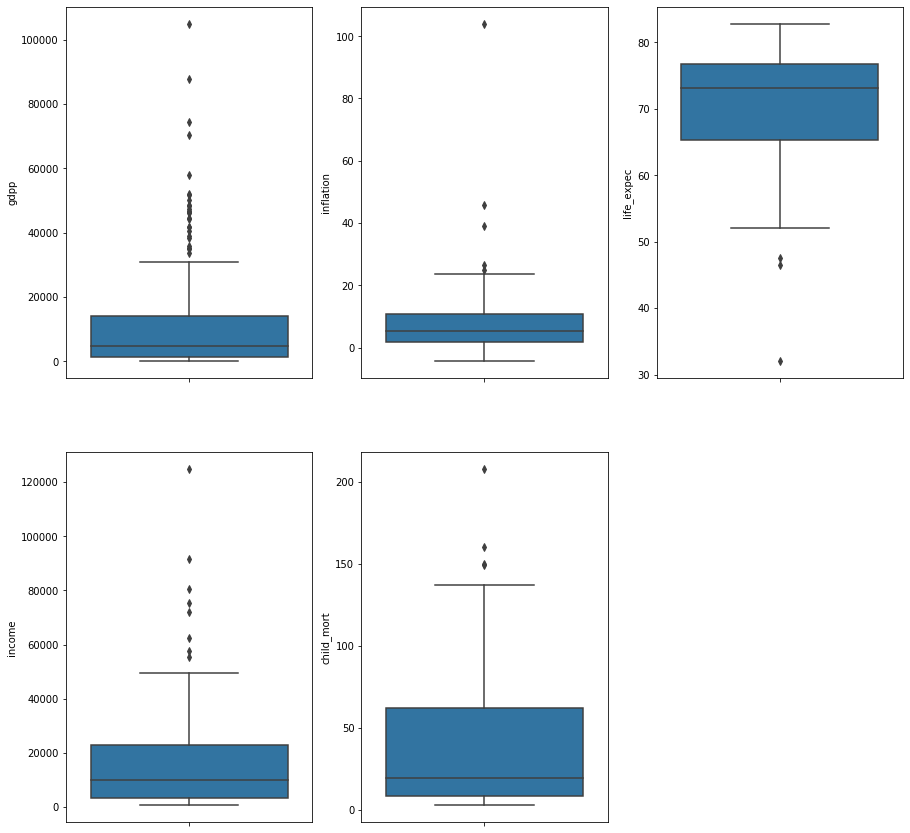

In [13]:
plt.figure(figsize = (15, 15))

plt.subplot(2, 3, 1)
sns.boxplot(data.gdpp, orient='v')

plt.subplot(2, 3, 2)
sns.boxplot(data.inflation, orient='v')

plt.subplot(2, 3, 3)
sns.boxplot(data.life_expec, orient='v')

plt.subplot(2, 3, 4)
sns.boxplot(data.income, orient='v')

plt.subplot(2, 3, 5)
sns.boxplot(data.child_mort, orient='v')

In [14]:
# plt.figure(figsize = (6, 8))
# # plt.subplot(2, 3, 1)
# sns.boxplot(data.health, orient='v')

In [15]:
# data.sort_values(by='health', ascending =False).head(5)

In [16]:
# data.sort_values(by='health', ascending =True).head(5)

### Observation
- Above 8 graphs indicate there are outliers in almost all columns. 
- These may be related. 

Let's look at the correlation of the of all the columns

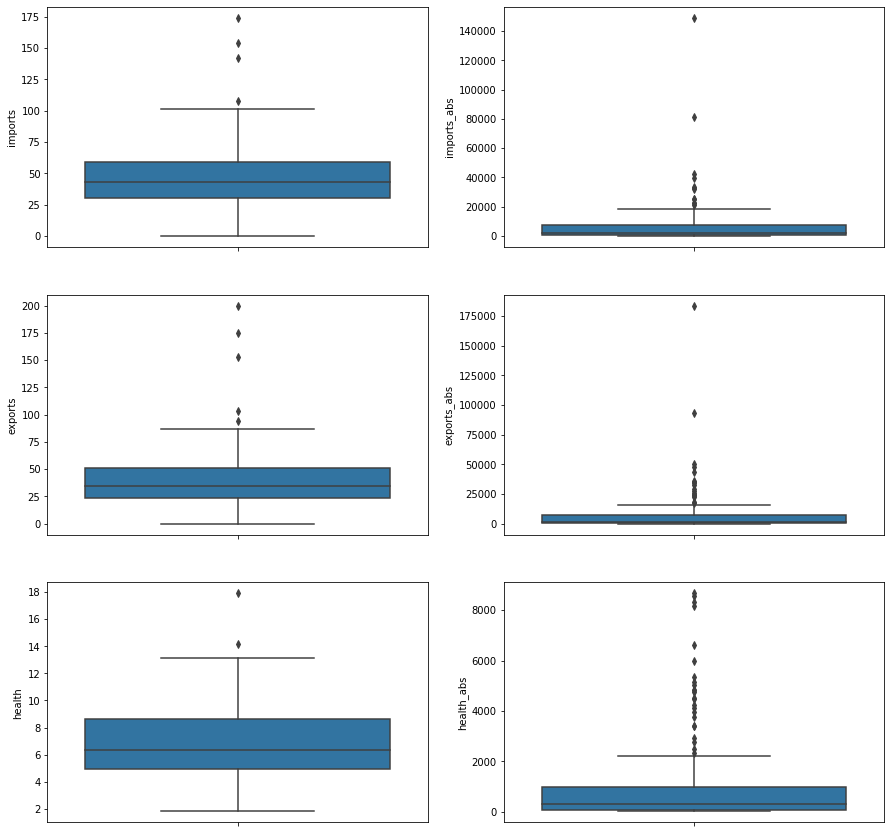

In [17]:
plt.figure(figsize = (15, 15))
plt.subplot(3, 2, 1)
sns.boxplot(data.imports, orient='v')

plt.subplot(3, 2, 2)
sns.boxplot(data.imports_abs, orient='v')

plt.subplot(3, 2, 3)
sns.boxplot(data.exports, orient='v')

plt.subplot(3, 2, 4)
sns.boxplot(data.exports_abs, orient='v')

plt.subplot(3, 2, 5)
sns.boxplot(data.health, orient='v')

plt.subplot(3, 2, 6)
sns.boxplot(data.health_abs, orient='v')

### Observation
- Few countries seem to be spending high percentage of gdp on health. 
- Absolute value of export are limited in a range. however, there are few countries doing high %age of exports

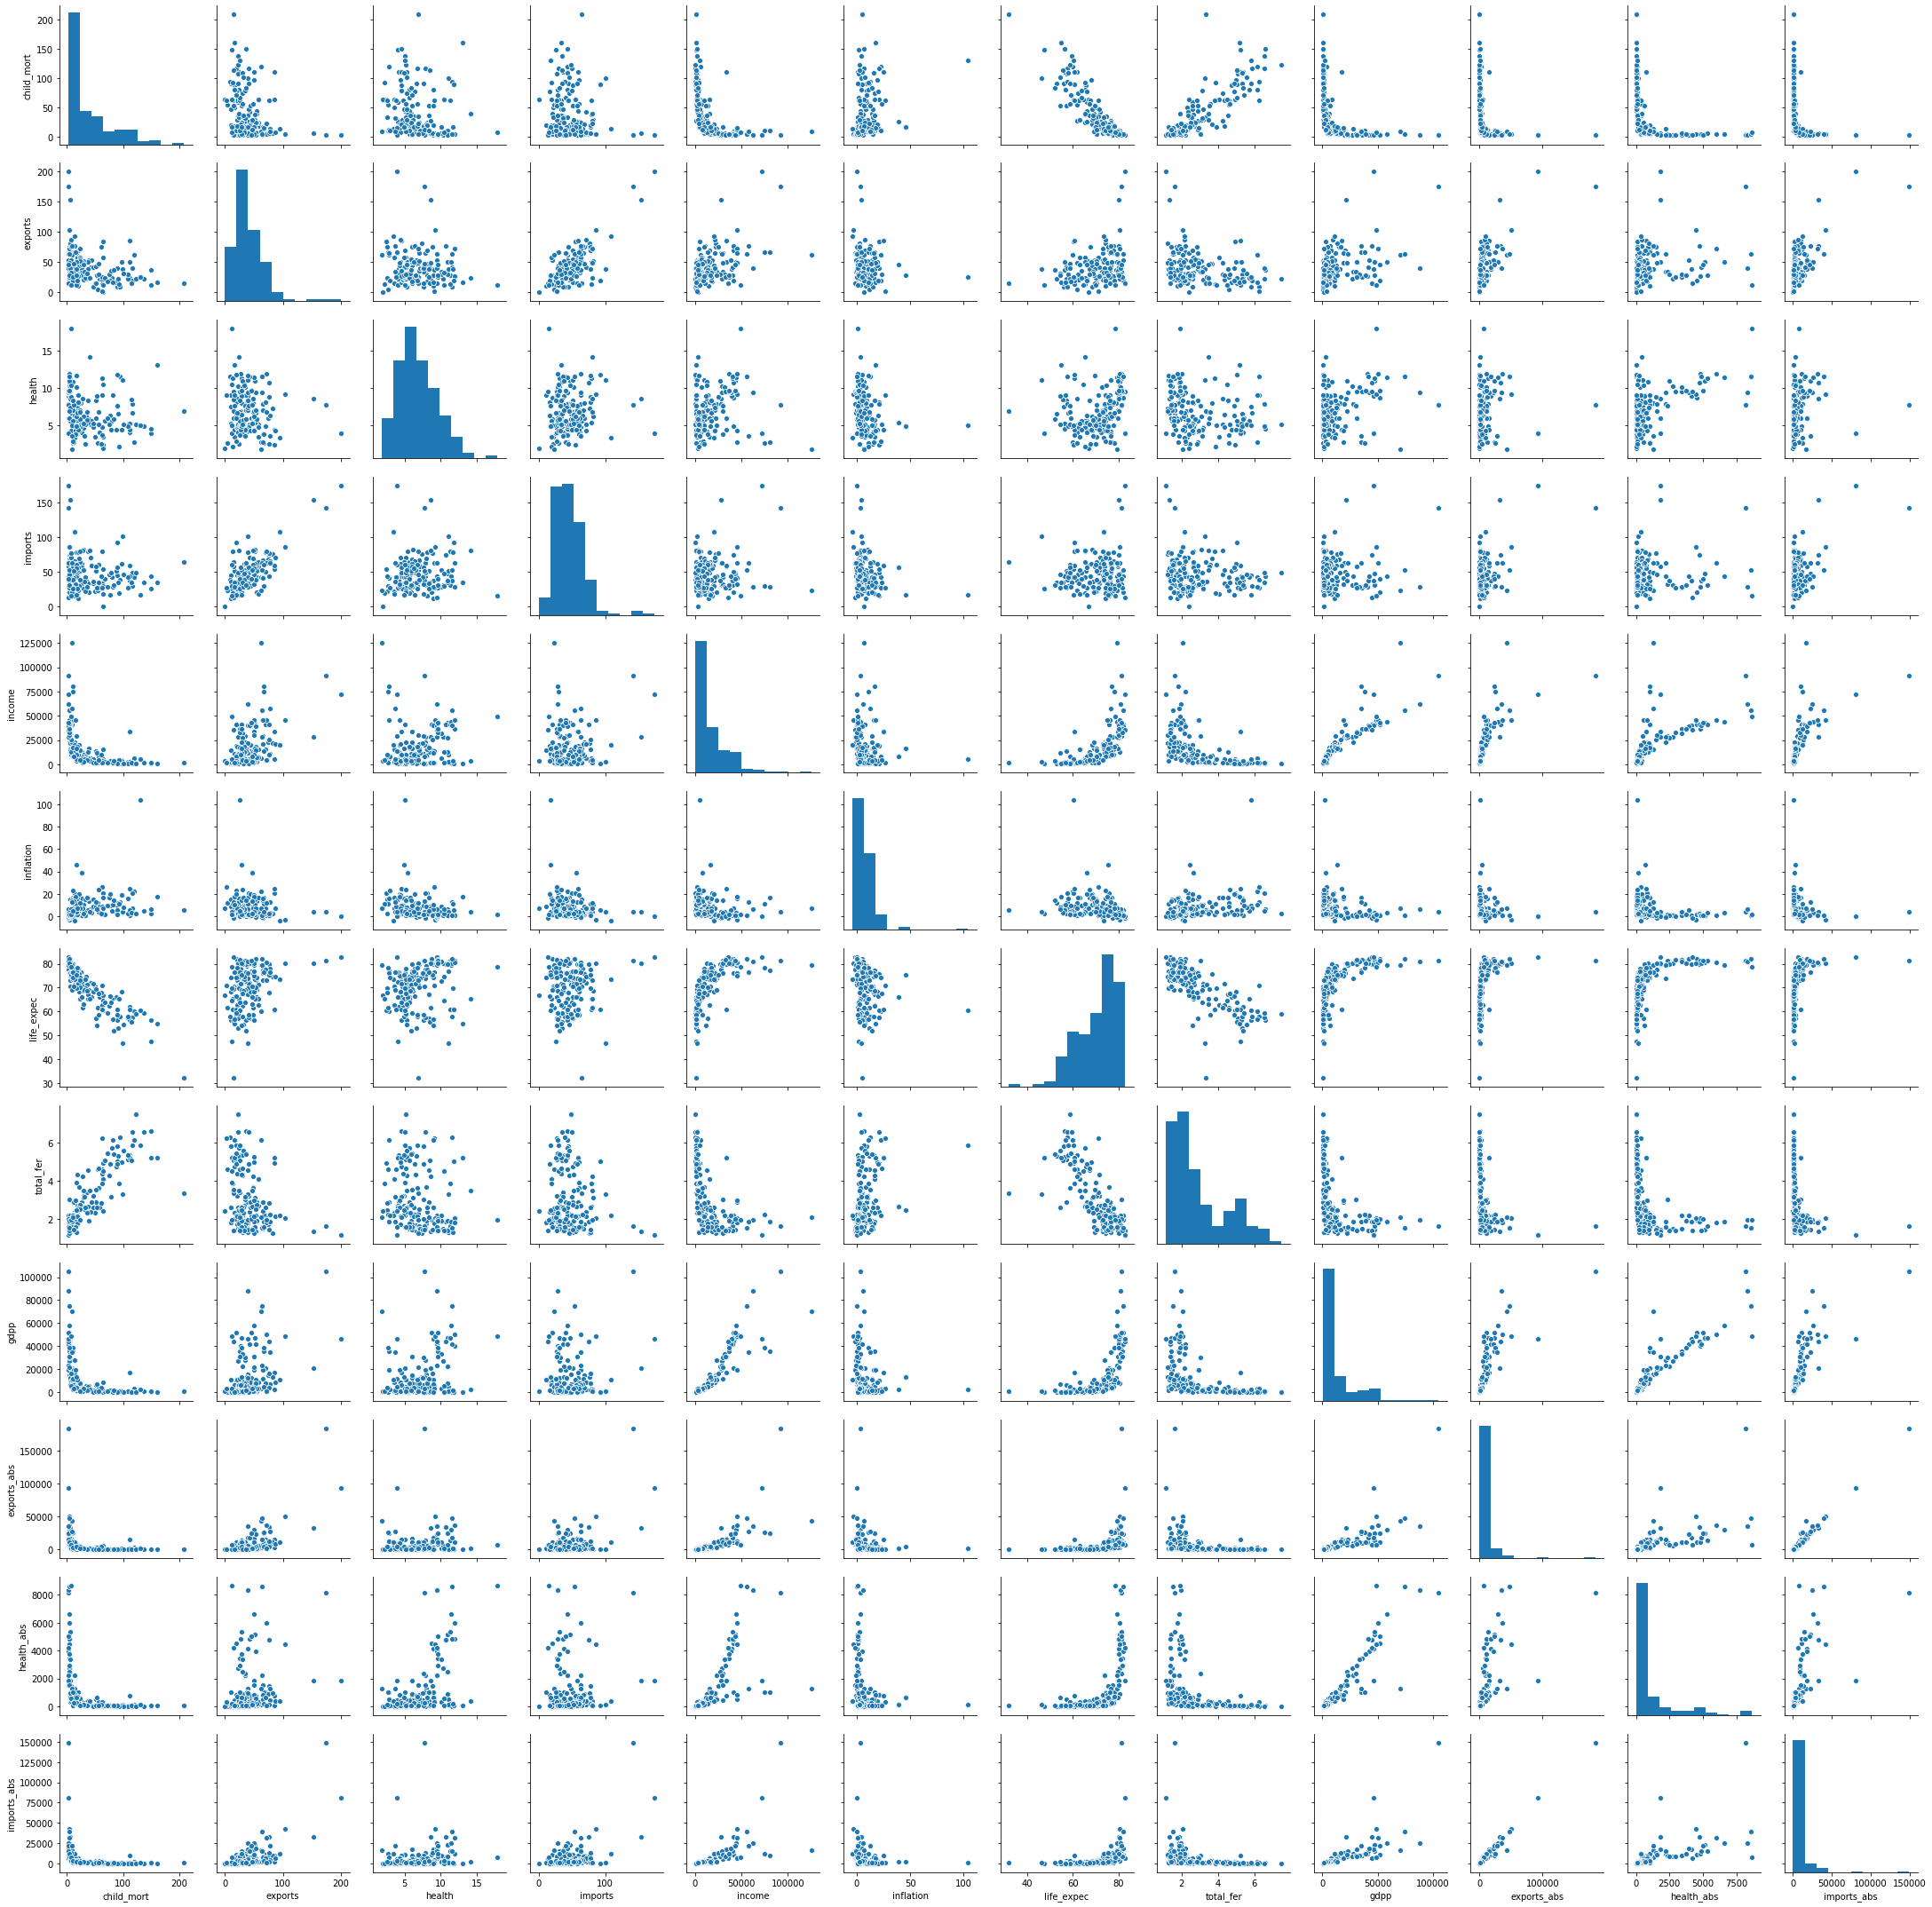

In [18]:
sns.pairplot(data=data)

### Observations 
- For countries with low gdp range of child mortality rate is broad. 
- but for countries with high gdp, the child mortality rate is mostly low. 
- imports and exports are range bound. we wil have to explore it further. Some countries with high gdp might be importing some specific things and exporting other things in similar amounts hence balancing the scale. 

- Income and gdpp have linear relationship. 
- total_fert and life_expec are highly correlated.

Let's dig deeper into following pairs
- gdp and health spendings
- gdp and imports
- import and export patterns
- child mortality rate and health spendings
- life expectancy and health spendings.
- inflation and gdpp

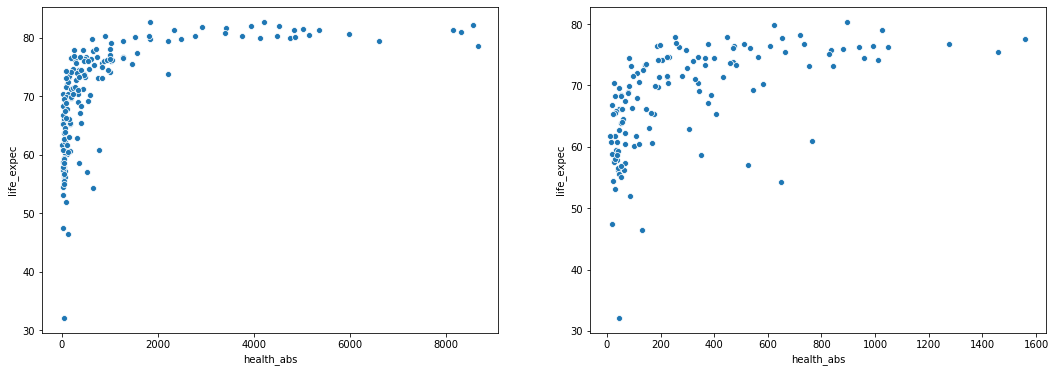

In [19]:
# life expectancy and health spendings.
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='health_abs', y='life_expec')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data.loc[data['gdpp']<20000], x='health_abs', y='life_expec')

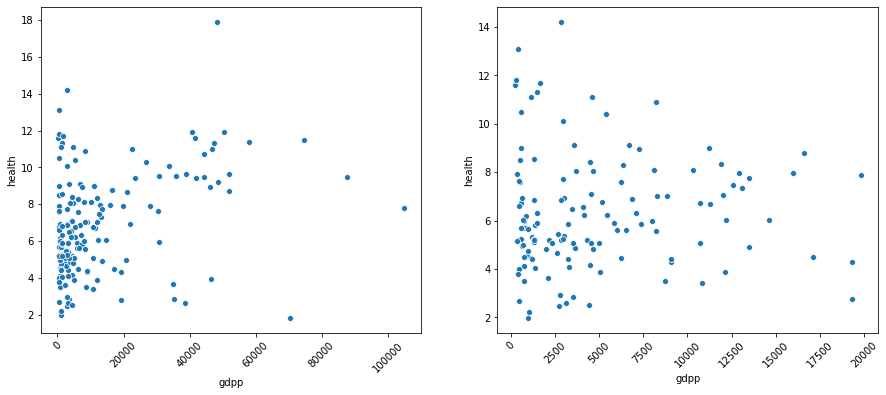

In [20]:
# gdpp and health spendings.
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.scatterplot(data=data, y='health', x='gdpp')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.scatterplot(data=data.loc[data['gdpp']<20000], y='health', x='gdpp')

(0, 2500)

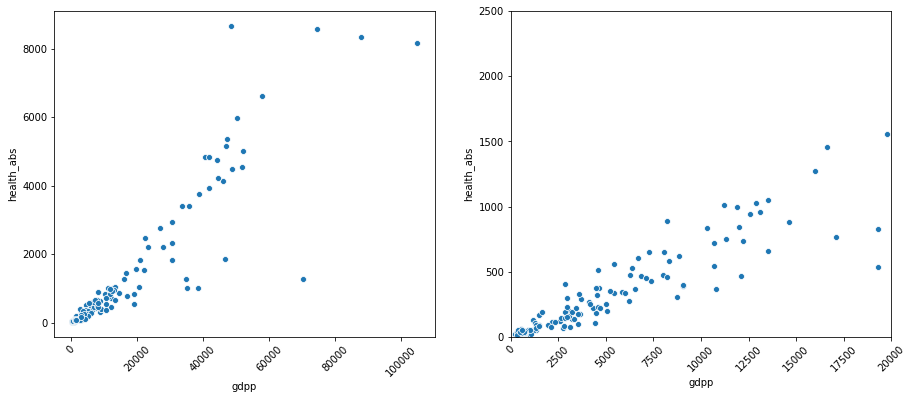

In [21]:
# gdpp and health spendings.
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.scatterplot(data=data, y='health_abs', x='gdpp')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.scatterplot(data=data, y='health_abs', x='gdpp')
plt.xlim( 0,20000)
plt.ylim( 0,2500)

(0, 2500)

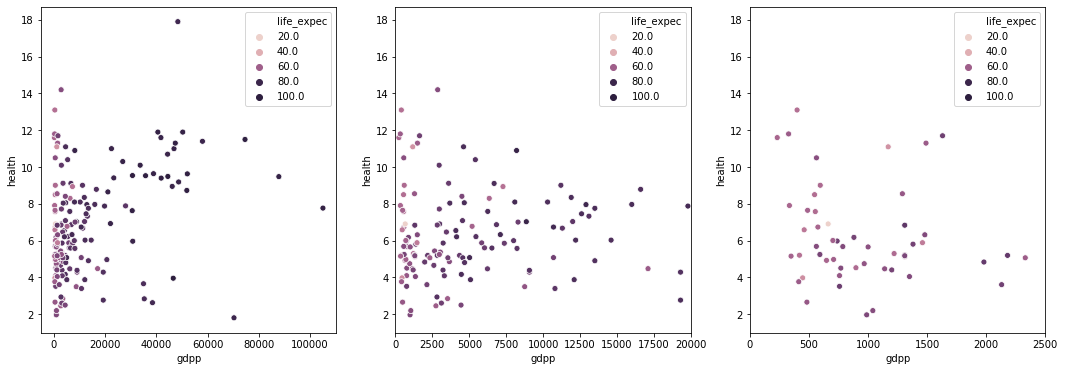

In [22]:
# gdp , health and life_expe
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='gdpp', y='health', hue='life_expec')


plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='gdpp', y='health', hue='life_expec')
plt.xlim( 0,20000)

# countries with low gpd
plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='gdpp', y='health', hue='life_expec')
plt.xlim( 0,2500)

(0, 200)

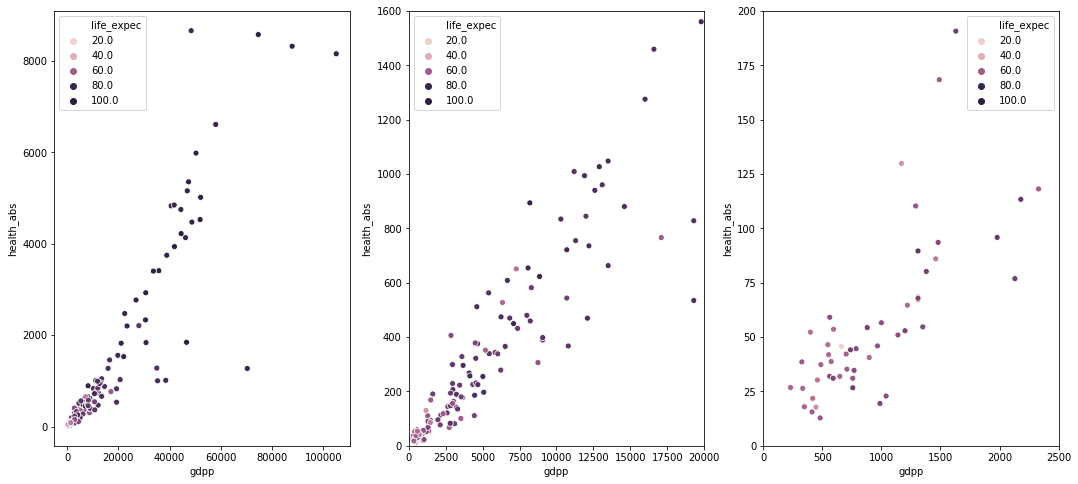

In [23]:
# gdp , health and life_expe
plt.figure(figsize=(18,8))
plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='life_expec')


plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='life_expec')
plt.xlim( 0,20000)
plt.ylim( 0,1600)

# countries with low gpd
plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='life_expec')
plt.xlim( 0,2500)
plt.ylim( 0,200)


### Observation
- health spending gradually increases with GDP. 
- life expectancy is high in countries with high-gdp
- life expectancy is low in countries with less gdp even in cases where spending on health is high



(0, 5000)

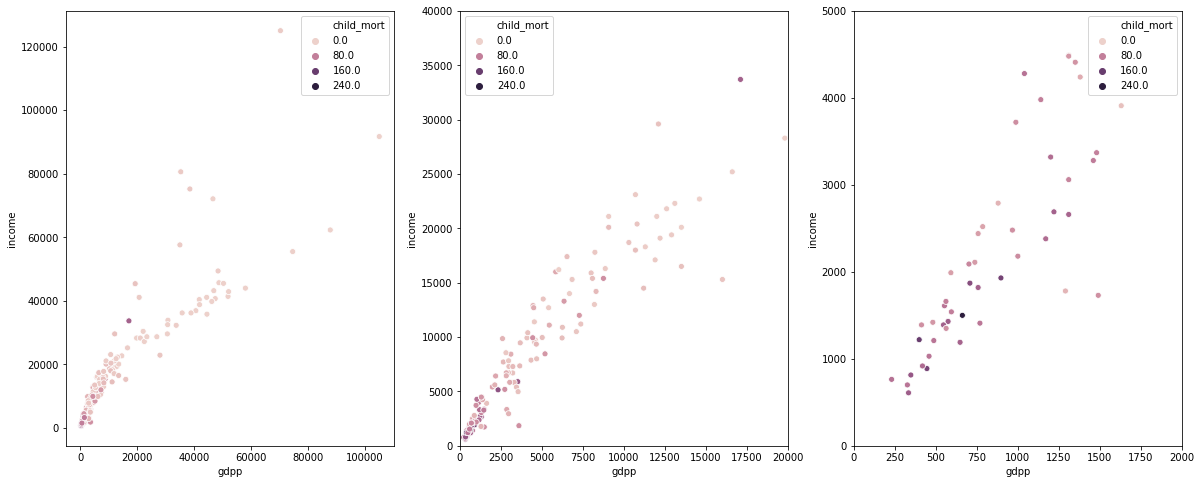

In [24]:
# gdp , income and child_mort
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='gdpp', y='income', hue='child_mort')

# countries with low gpd
plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='gdpp', y='income', hue='child_mort')
plt.xlim( 0,20000)
plt.ylim( 0,40000)


plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='gdpp', y='income', hue='child_mort')
plt.xlim( 0,2000)
plt.ylim( 0,5000)

### Observation 
- Countries with low GDP and low income have high child mortality rate. It becomes clear as narrow down the visual area.(Graph 3)

(0, 200)

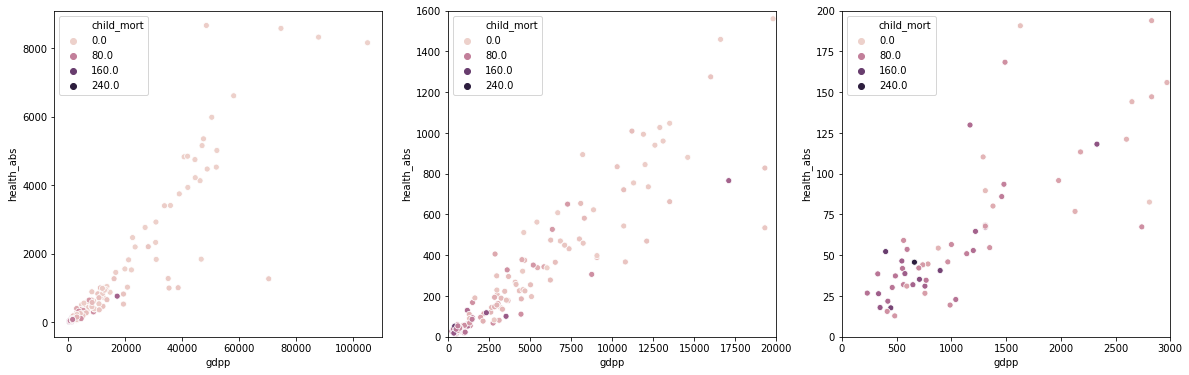

In [25]:
# gdp , health_abs and child_mort
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='child_mort')

# countries with low gpd
plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='child_mort')
plt.xlim( 0,20000)
plt.ylim( 0,1600)

plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='gdpp', y='health_abs', hue='child_mort')
plt.xlim( 0,3000)
plt.ylim( 0,200)

### Observation 
- Countries with low GDP and low spending on health have high child mortality rate. It becomes clear as narrow down the visual area.(Graph 3)

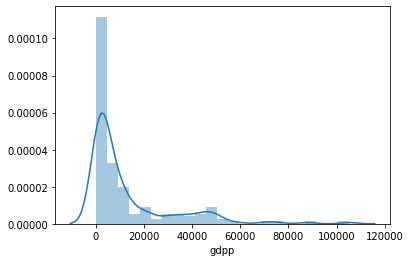

In [26]:
sns.distplot(data['gdpp'])

## Outlier handling

#### Observations for gdpp column.
- there are very few countries with gdp >60000 and even lesser for 80000

In [27]:
data.gdpp.describe(percentiles= [0.1, 0.25,0.5,0.75,.85,.9,.95, 0.99])

count       167.000000
mean      12964.155689
std       18328.704809
min         231.000000
10%         593.800000
25%        1330.000000
50%        4660.000000
75%       14050.000000
85%       31090.000000
90%       41840.000000
95%       48610.000000
99%       79088.000000
max      105000.000000
Name: gdpp, dtype: float64

In [28]:
data.loc[data.gdpp>60000]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,183750.0,8158.50,149100.0
114,Norway,3.2,39.7,9.48,28.5,62300,5.950,81.0,1.95,87800,34856.6,8323.44,25023.0
123,Qatar,9.0,62.3,1.81,23.8,125000,6.980,79.5,2.07,70300,43796.9,1272.43,16731.4
145,Switzerland,4.5,64.0,11.50,53.3,55500,0.317,82.2,1.52,74600,47744.0,8579.00,39761.8


### Observation
- above countries have all factors as good. 
    - high gdp,
    - low mortality rate,
    - high income per person
    - high life expectancy. 
    - Luxembourg clearly does exports over and above its gdp but so are its imports. it is a country rich through trade 
    
Since we are looking at countries for aid there can be 2 ways to handle this. 
1. drop these columns as these country do not need much aid. 
2. group them into one cluster and just not consider the cluster for aid. 

In [29]:
# lets leave these countries for now. 

newData = data.loc[data.gdpp<=60000]
newData.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800


In [30]:
newData.shape

(163, 13)

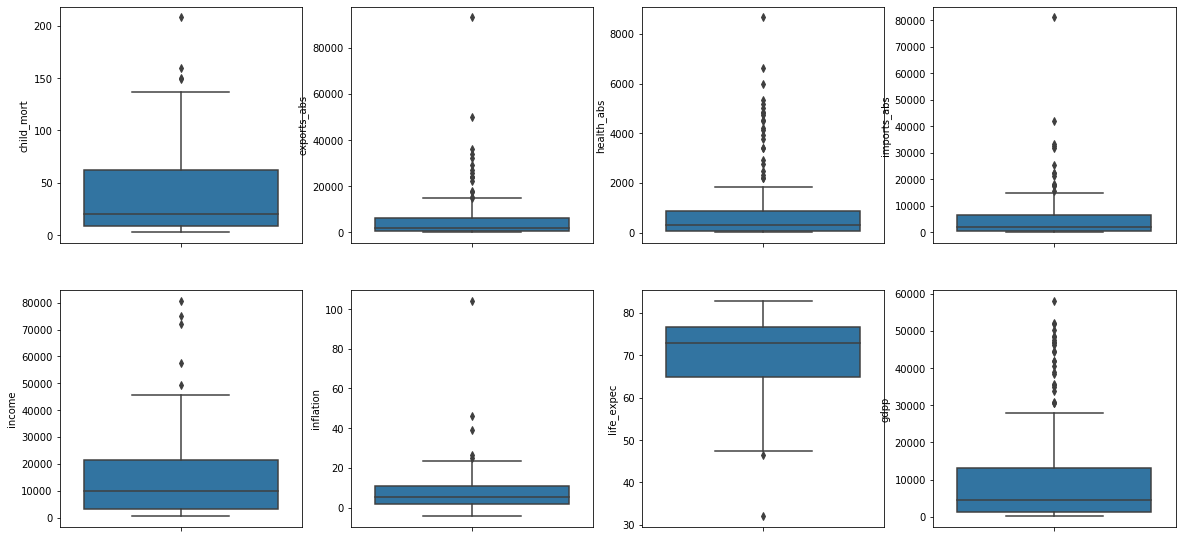

In [31]:
plt.figure(figsize = (20,20))
plt.subplot(4, 4, 1)
sns.boxplot(newData.child_mort, orient='v')

plt.subplot(4, 4, 2)
sns.boxplot(newData.exports_abs, orient='v')

plt.subplot(4, 4, 3)
sns.boxplot(newData.health_abs, orient='v')

plt.subplot(4, 4, 4)
sns.boxplot(newData.imports_abs, orient='v')

plt.subplot(4, 4, 5)
sns.boxplot(newData.income, orient='v')

plt.subplot(4, 4, 6)
sns.boxplot(newData.inflation, orient='v')

plt.subplot(4, 4,7)
sns.boxplot(newData.life_expec, orient='v')

plt.subplot(4, 4,8)
sns.boxplot(newData.gdpp, orient='v')


In [32]:
# looking at high inflation
newData.loc[newData.inflation>60]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330,589.49,118.131,405.42


### Observation
Clearly Nigeria has low gdpp, high mortality rate and inflation, low life_expectactancy. We cannot drop this as it makes a good candidate for aid

In [33]:
newData[newData.inflation<100].inflation.max()

45.9

In [34]:
newData.loc[newData.inflation>30, 'inflation'] = 46

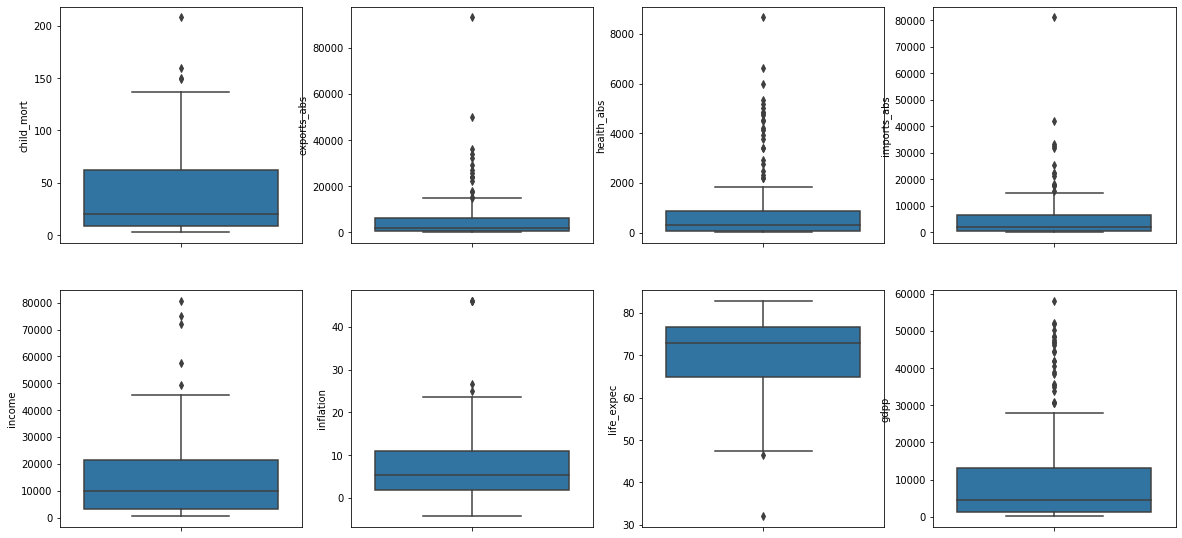

In [35]:
plt.figure(figsize = (20,20))
plt.subplot(4, 4, 1)
sns.boxplot(newData.child_mort, orient='v')

plt.subplot(4, 4, 2)
sns.boxplot(newData.exports_abs, orient='v')

plt.subplot(4, 4, 3)
sns.boxplot(newData.health_abs, orient='v')

plt.subplot(4, 4, 4)
sns.boxplot(newData.imports_abs, orient='v')

plt.subplot(4, 4, 5)
sns.boxplot(newData.income, orient='v')

plt.subplot(4, 4, 6)
sns.boxplot(newData.inflation, orient='v')

plt.subplot(4, 4,7)
sns.boxplot(newData.life_expec, orient='v')

plt.subplot(4, 4,8)
sns.boxplot(newData.gdpp, orient='v')


In [36]:
# looking at lowest life expactancy
newData.loc[newData.life_expec<40]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
66,Haiti,208.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,101.286,45.7442,428.314


### Observations
Hiati again has
- low GDP.
- Life expecatancy is very low. 
- income per person is low
- child mortality rate is high. 

this again makes a case for aid. we can not drop this as well. 


### Imports

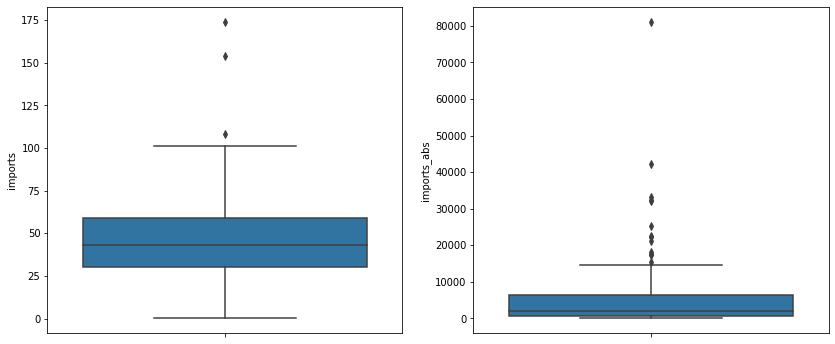

In [37]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(newData.imports, orient='v')

plt.subplot(1, 2, 2)
sns.boxplot(newData.imports_abs, orient='v')


In [38]:
newData.imports_abs.describe(percentiles= [0.1, 0.25,0.5,0.75,0.99])

count      163.000000
mean      5335.206148
std       9234.590895
min          0.651092
10%        206.523200
25%        581.655000
50%       1987.740000
75%       6404.350000
99%      36571.106000
max      81084.000000
Name: imports_abs, dtype: float64

In [39]:
newData.imports.describe(percentiles= [0.1, 0.25,0.5,0.75,0.95,.98,0.99])

count    163.000000
mean      46.521877
std       23.215691
min        0.065900
10%       22.440000
25%       30.550000
50%       43.300000
75%       58.750000
95%       80.920000
98%       98.984000
99%      125.480000
max      174.000000
Name: imports, dtype: float64

In [40]:
Q1 = newData.imports_abs.quantile(0.01)
Q2 = newData.imports_abs.quantile(0.99)

In [41]:
newData.loc[newData.imports_abs<=Q1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
26,Burundi,93.6,8.920,11.60,39.2000,764,12.30,57.7,6.26,231,20.60520,26.7960,90.552000
107,Myanmar,64.4,0.109,1.97,0.0659,3720,7.04,66.8,2.41,988,1.07692,19.4636,0.651092


### Observtions
Thought the absolute value of imports is on lower end, we observe that gpp for both the countries is low. 
However, 'Burundi' however spends considerable %age(39.2) of Gdp on imports while export percentage is very low. Child_mort rate is high. this implies that country does not have enough resources to sustain and is largely dependent on imports. 

For myanmar , it looks like they don't trade much. But spending on health is low and child mortality is high. might be a case for some support

In [42]:
newData.loc[newData.imports_abs>=Q2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
73,Ireland,4.2,103.0,9.19,86.5,45700,-3.220,80.4,2.05,48700,50161.0,4475.53,42125.5
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,93200.0,1845.36,81084.0


### Observations
- Countries with values > 99 %ile have high imprts and exports. This implies they are trade rich.
- Gdpp is decent 
- child_mort is low 
so these don't make case for support. we can cap these imports to 100%

### Exports

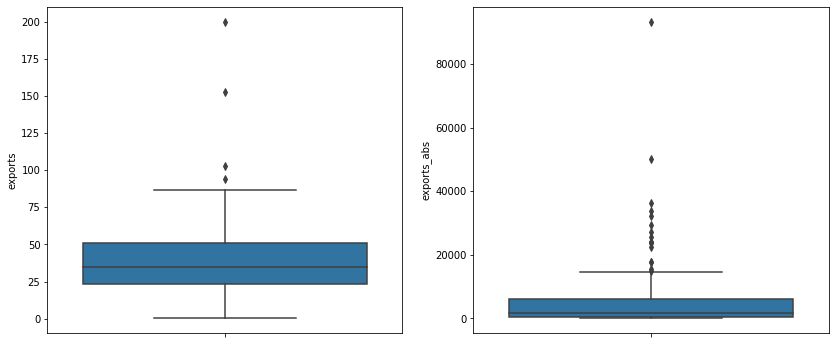

In [43]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(newData.exports, orient='v')

plt.subplot(1, 2, 2)
sns.boxplot(newData.exports_abs, orient='v')


In [44]:
newData.exports_abs.describe(percentiles= [0.1, 0.25,0.5,0.75,0.99])

count      163.000000
mean      5699.974525
std      10643.343003
min          1.076920
10%        110.049600
25%        438.830000
50%       1754.060000
75%       6194.050000
99%      41515.100000
max      93200.000000
Name: exports_abs, dtype: float64

In [45]:
newData.exports.describe(percentiles= [0.1, 0.25,0.5,0.75,0.95,.98,0.99])

count    163.000000
mean      40.025761
std       25.536506
min        0.109000
10%       15.420000
25%       23.650000
50%       35.000000
75%       50.950000
95%       77.690000
98%       92.144000
99%      122.000000
max      200.000000
Name: exports, dtype: float64

In [46]:
Q1 = newData.exports_abs.quantile(0.01)
Q2 = newData.exports_abs.quantile(0.99)

In [47]:
newData.loc[newData.exports_abs<=Q1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
26,Burundi,93.6,8.920,11.60,39.2000,764,12.30,57.7,6.26,231,20.60520,26.7960,90.552000
107,Myanmar,64.4,0.109,1.97,0.0659,3720,7.04,66.8,2.41,988,1.07692,19.4636,0.651092


In [48]:
newData.loc[newData.exports_abs>=Q2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
73,Ireland,4.2,103.0,9.19,86.5,45700,-3.220,80.4,2.05,48700,50161.0,4475.53,42125.5
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,93200.0,1845.36,81084.0


### Observations
For exports same results are returned for both sides as in case of imports. We can cap these at 100

In [49]:
# capping imports and exports to 100
newData.loc[newData.exports_abs>=Q2, 'imports'] = 100
newData.loc[newData.exports_abs>=Q2, 'exports'] = 100

In [50]:
newData['exports_abs'] = newData.exports * newData.gdpp
newData['imports_abs'] = newData.imports * newData.gdpp

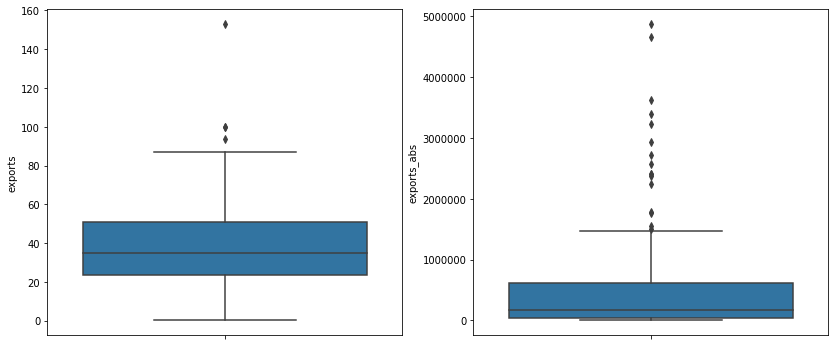

In [51]:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(newData.exports, orient='v')

plt.subplot(1, 2, 2)
sns.boxplot(newData.exports_abs, orient='v')


In [52]:
# we still have outliers. let's take a look
newData.sort_values(by='exports', ascending = False).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,3228300.0,1825.150,3249400.0
73,Ireland,4.2,100.0,9.19,100.0,45700,-3.220,80.4,2.05,48700,4870000.0,4475.530,4870000.0
133,Singapore,2.8,100.0,3.96,100.0,72100,-0.046,82.7,1.15,46600,4660000.0,1845.360,4660000.0
131,Seychelles,14.4,93.8,3.40,108.0,20400,-4.210,73.4,2.17,10800,1013040.0,367.200,1166400.0
95,Malaysia,7.9,86.9,4.39,71.0,21100,7.270,74.5,2.15,9070,788183.0,398.173,643970.0
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.900,60.9,5.21,17100,1467180.0,766.080,1007190.0
38,"Congo, Rep.",63.9,85.1,2.46,54.7,5190,20.700,60.4,4.95,2740,233174.0,67.404,149878.0
67,Hungary,6.0,81.8,7.33,76.5,22300,2.330,74.5,1.25,13100,1071580.0,960.230,1002150.0
157,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000,2719500.0,1281.000,2226000.0
96,Maldives,13.2,77.6,6.33,65.4,10500,2.880,77.9,2.23,7100,550960.0,449.430,464340.0


In [53]:
# it makes sense to cap these at 100
newData.loc[newData.imports>100, 'imports'] = 100
newData.loc[newData.exports>100, 'exports'] = 100

In [54]:
newData.sort_values(by='exports', ascending = False).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
73,Ireland,4.2,100.0,9.19,100.0,45700,-3.220,80.4,2.05,48700,4870000.0,4475.530,4870000.0
98,Malta,6.8,100.0,8.65,100.0,28300,3.830,80.3,1.36,21100,3228300.0,1825.150,3249400.0
133,Singapore,2.8,100.0,3.96,100.0,72100,-0.046,82.7,1.15,46600,4660000.0,1845.360,4660000.0
131,Seychelles,14.4,93.8,3.40,100.0,20400,-4.210,73.4,2.17,10800,1013040.0,367.200,1166400.0
95,Malaysia,7.9,86.9,4.39,71.0,21100,7.270,74.5,2.15,9070,788183.0,398.173,643970.0
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.900,60.9,5.21,17100,1467180.0,766.080,1007190.0
38,"Congo, Rep.",63.9,85.1,2.46,54.7,5190,20.700,60.4,4.95,2740,233174.0,67.404,149878.0
67,Hungary,6.0,81.8,7.33,76.5,22300,2.330,74.5,1.25,13100,1071580.0,960.230,1002150.0
157,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000,2719500.0,1281.000,2226000.0
96,Maldives,13.2,77.6,6.33,65.4,10500,2.880,77.9,2.23,7100,550960.0,449.430,464340.0


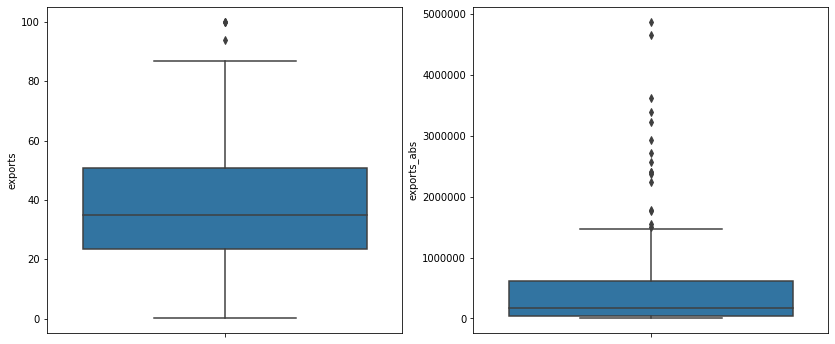

In [55]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(newData.exports, orient='v')

plt.subplot(1, 2, 2)
sns.boxplot(newData.exports_abs, orient='v')


### Child Mortality

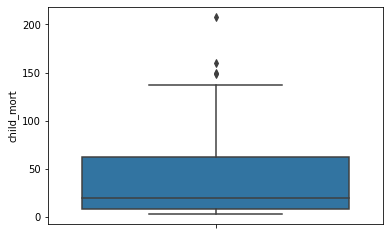

In [56]:
sns.boxplot(newData.child_mort, orient='v')

In [57]:
newData.sort_values(by='child_mort', ascending = False).head(15)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
66,Haiti,208.0,15.3,6.91,64.7,1500,5.450,32.1,3.33,662,10128.6,45.7442,42831.4
132,Sierra Leone,160.0,16.8,13.10,34.5,1220,17.200,55.0,5.20,399,6703.2,52.2690,13765.5
32,Chad,150.0,36.8,4.53,43.5,1930,6.390,56.5,6.59,897,33009.6,40.6341,39019.5
31,Central African Republic,149.0,11.8,3.98,26.5,888,2.010,47.5,5.21,446,5262.8,17.7508,11819.0
97,Mali,137.0,22.8,4.98,35.1,1870,4.370,59.5,6.55,708,16142.4,35.2584,24850.8
113,Nigeria,130.0,25.3,5.07,17.4,5150,46.000,60.5,5.84,2330,58949.0,118.1310,40542.0
112,Niger,123.0,22.2,5.16,49.1,814,2.550,58.8,7.49,348,7725.6,17.9568,17086.8
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,219919.0,100.6050,151437.0
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575,11040.0,38.7550,17020.0
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.800,57.5,6.54,334,13727.4,26.4194,16566.4


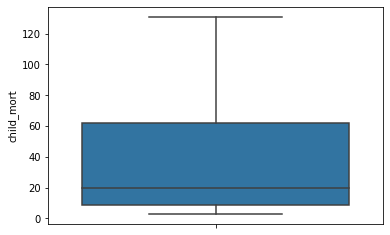

In [58]:
newData.loc[newData.child_mort>130, 'child_mort'] = 131
sns.boxplot(newData.child_mort, orient='v')

## Hopkins check

In [59]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [60]:
countriesInfo= newData.drop(['country', 'exports', 'imports', 'health'], inplace=False, axis = 1)
countriesInfo.head()


,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,90.2,1610,9.44,56.2,5.82,553,5530.0,41.9174,24829.7
1,16.6,9930,4.49,76.3,1.65,4090,114520.0,267.8950,198774.0
2,27.3,12900,16.10,76.5,2.89,4460,171264.0,185.9820,140044.0
3,119.0,5900,22.40,60.1,6.16,3530,219919.0,100.6050,151437.0
4,10.3,19100,1.44,76.8,2.13,12200,555100.0,735.6600,718580.0


In [61]:
hopkins(countriesInfo)

0.9804073097559848

####  Hopkins statistics is pretty high, so we can do clustering. 

### Rescaling

In [62]:
scaler = StandardScaler()

# fit_transform
countries_info_scaled = scaler.fit_transform(countriesInfo)
countries_info_scaled = pd.DataFrame(countries_info_scaled)

In [63]:
# remove percentages and strings before rescaling
countries_info_scaled.columns = countriesInfo.columns
countries_info_scaled.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,1.383835,-0.881403,0.227841,-1.598714,1.875433,-0.736757,-0.617717,-0.579018,-0.618323
1,-0.573900,-0.353953,-0.370729,0.680403,-0.874719,-0.492243,-0.491872,-0.430194,-0.399526
2,-0.289284,-0.165669,1.033188,0.703081,-0.056928,-0.466665,-0.426352,-0.484140,-0.473400
3,2.149905,-0.609437,1.795004,-1.156498,2.099666,-0.530956,-0.370173,-0.540368,-0.459069
4,-0.741478,0.227382,-0.739544,0.737098,-0.558155,0.068403,0.016844,-0.122134,0.254316


## Hierarchical Clustering

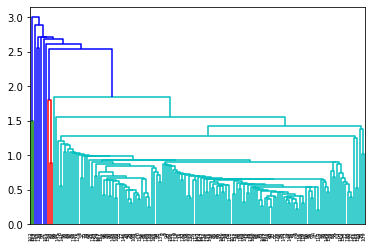

In [64]:
# single linkage
mergings = linkage(countries_info_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

#### The dendrogram is not very descriptive or readable. However, colors indicate that we may have 3 different clusters. We can explore complete linkage  for clarification

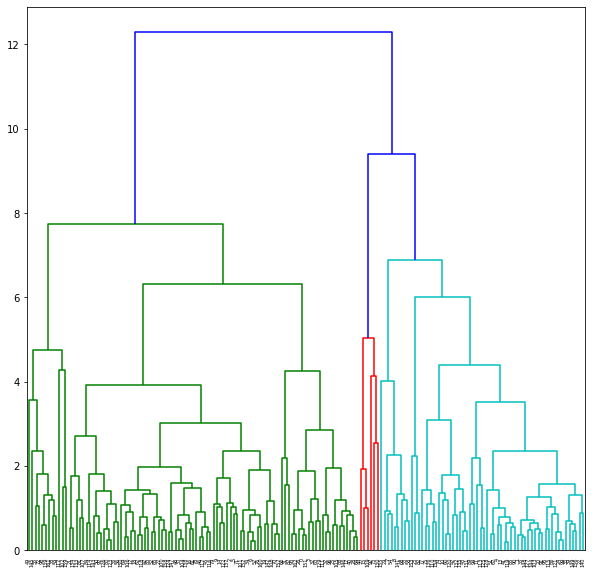

In [65]:
# complete linkage
plt.figure(figsize=(10,10))
mergings = linkage(countries_info_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [66]:
# 2 clusters
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
newData['cluster_labels'] = cluster_labels
twoClustersData = newData.copy(deep=True)
newData.drop('cluster_labels', axis=1, inplace=True)


In [67]:
twoClustersData.groupby('cluster_labels')['gdpp'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,97.0,2889.010309,2967.225772,231.0,758.0,1980.0,3650.0,17100.0
1,66.0,23440.606061,16016.072397,4090.0,9477.5,19300.0,37825.0,58000.0


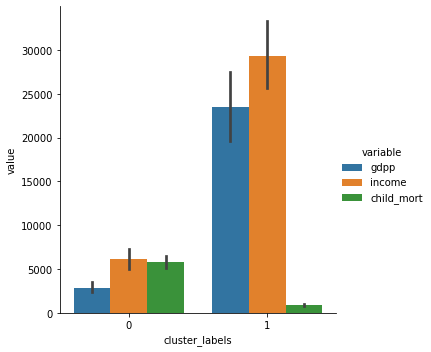

In [68]:
pltData = pd.melt(twoClustersData, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='bar')

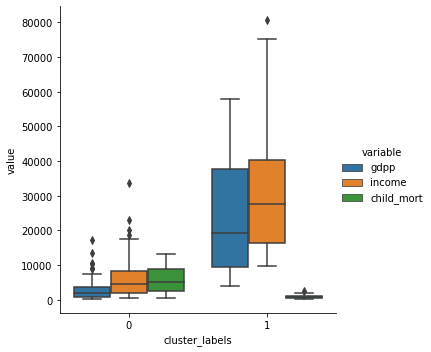

In [69]:
pltData = pd.melt(twoClustersData, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='box')

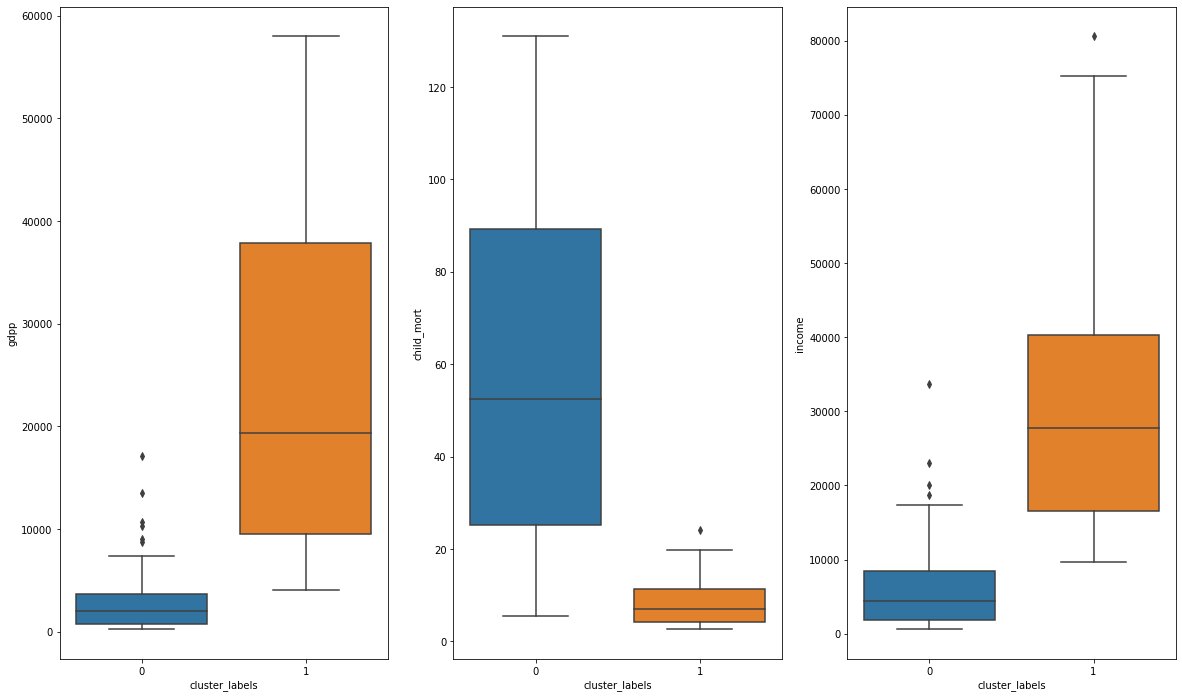

In [70]:
# plots
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_labels', y='gdpp', data=twoClustersData)

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_labels', y='child_mort', data=twoClustersData)

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_labels', y='income', data=twoClustersData)

In [71]:
twoClustersData.loc[(twoClustersData.cluster_labels==0)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2060.52,26.7960,9055.2,0
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,6245.70,38.5860,30280.2,0
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,13727.40,26.4194,16566.4,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,7725.60,17.9568,17086.8,0
132,Sierra Leone,131.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,6703.20,52.2690,13765.5,0
93,Madagascar,62.2,25.00,3.77,43.0,1390,8.79,60.8,4.60,413,10325.00,15.5701,17759.0,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,13198.50,21.8299,19357.8,0
31,Central African Republic,131.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,5262.80,17.7508,11819.0,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,10465.20,30.2481,16019.1,0
50,Eritrea,55.2,4.79,2.66,23.3,1420,11.60,61.7,4.61,482,2308.78,12.8212,11230.6,0


In [72]:
twoClustersData.loc[(twoClustersData.cluster_labels==0)].sort_values(by=['child_mort', 'income', 'gdpp' ], ascending = [False, True, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
31,Central African Republic,131.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,5262.8,17.7508,11819.0,0
132,Sierra Leone,131.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,6703.2,52.2690,13765.5,0
66,Haiti,131.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,10128.6,45.7442,42831.4,0
97,Mali,131.0,22.8,4.98,35.1,1870,4.37,59.5,6.55,708,16142.4,35.2584,24850.8,0
32,Chad,131.0,36.8,4.53,43.5,1930,6.39,56.5,6.59,897,33009.6,40.6341,39019.5,0
113,Nigeria,130.0,25.3,5.07,17.4,5150,46.00,60.5,5.84,2330,58949.0,118.1310,40542.0,0
112,Niger,123.0,22.2,5.16,49.1,814,2.55,58.8,7.49,348,7725.6,17.9568,17086.8,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,219919.0,100.6050,151437.0,0
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334,13727.4,26.4194,16566.4,0
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,11040.0,38.7550,17020.0,0


### 3 clusters

In [73]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

In [74]:
# assign cluster labels
newData['cluster_labels'] = cluster_labels
hierachicalResult3 = newData.copy(deep=True)
newData.drop('cluster_labels', axis=1, inplace=True)
hierachicalResult3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,5530.0,41.9174,24829.7,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,114520.0,267.8950,198774.0,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,171264.0,185.9820,140044.0,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,219919.0,100.6050,151437.0,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,555100.0,735.6600,718580.0,1


In [75]:
hierachicalResult3.groupby('cluster_labels')['gdpp'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,97.0,2889.010309,2967.225772,231.0,758.0,1980.0,3650.0,17100.0
1,60.0,21299.666667,14765.673771,4090.0,8720.0,15300.0,34025.0,52100.0
2,6.0,44850.000000,12528.168262,21100.0,44950.0,47650.0,49900.0,58000.0


In [76]:
hierachicalResult3.groupby('cluster_labels')['child_mort'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,97.0,58.241237,37.098357,5.5,25.100,52.50,89.300,131.0
1,60.0,9.105000,5.321572,2.6,4.450,7.70,12.075,24.1
2,6.0,4.483333,1.298332,2.8,4.125,4.35,4.500,6.8


In [77]:
hierachicalResult3.groupby('cluster_labels')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,97.0,6119.721649,5691.372229,609.0,1870.0,4410.0,8430.0,33700.0
1,60.0,27639.166667,15084.216276,9720.0,15775.0,22800.0,36375.0,80600.0
2,6.0,46116.666667,14302.225934,28300.0,41825.0,44750.0,45650.0,72100.0


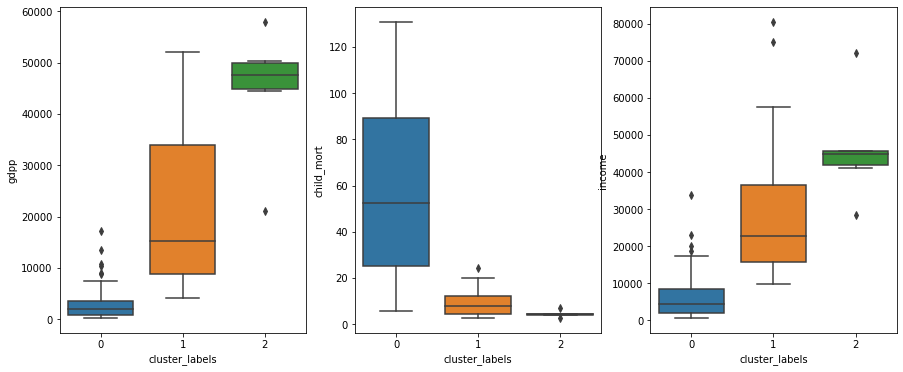

In [78]:
# plots
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_labels', y='gdpp', data=hierachicalResult3)

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_labels', y='child_mort', data=hierachicalResult3)

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_labels', y='income', data=hierachicalResult3)

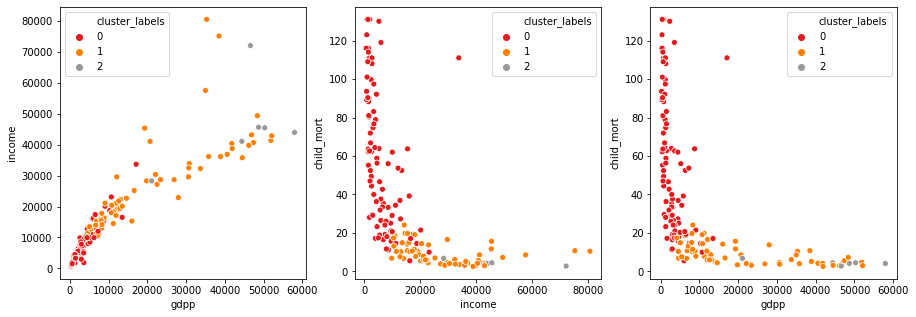

In [79]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='income', hue='cluster_labels', legend='full', data = hierachicalResult3, palette='Set1')
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_labels', legend='full', data = hierachicalResult3, palette='Set1')
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_labels', legend='full', data = hierachicalResult3, palette='Set1')


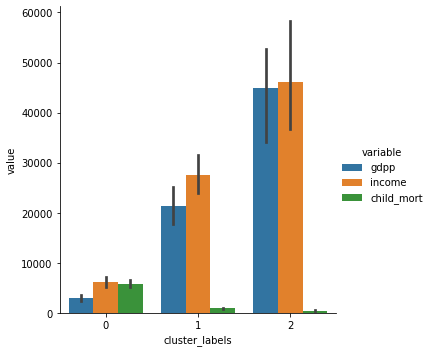

In [80]:
pltData = pd.melt(hierachicalResult3, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='bar')

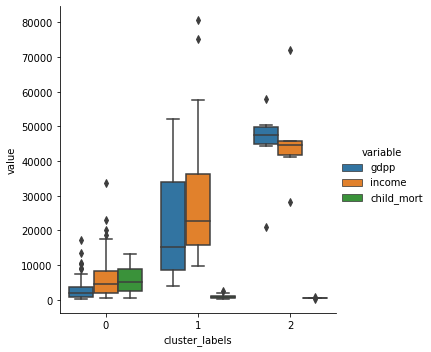

In [81]:
pltData = pd.melt(hierachicalResult3, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='box')

### Observation
- The three clusters clearly have different characterstics as depicted by the graphs above. 
- These are divided into low gdp, high gdp and the middle range. 
- Child moratlity rate and incomes are also distinctly different. 
- Relationships identified during EDA hold. 

### Deriving the 5 countries that need aid. 

In [82]:
hierachicalResult3.loc[(hierachicalResult3.cluster_labels==0)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2060.52,26.7960,9055.2,0
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,6245.70,38.5860,30280.2,0
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,13727.40,26.4194,16566.4,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,7725.60,17.9568,17086.8,0
132,Sierra Leone,131.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,6703.20,52.2690,13765.5,0
93,Madagascar,62.2,25.00,3.77,43.0,1390,8.79,60.8,4.60,413,10325.00,15.5701,17759.0,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,13198.50,21.8299,19357.8,0
31,Central African Republic,131.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,5262.80,17.7508,11819.0,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,10465.20,30.2481,16019.1,0
50,Eritrea,55.2,4.79,2.66,23.3,1420,11.60,61.7,4.61,482,2308.78,12.8212,11230.6,0


In [83]:
hierachicalResult3.loc[(hierachicalResult3.cluster_labels==0)].sort_values(by=['child_mort', 'income', 'gdpp' ], ascending = [False, True, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
31,Central African Republic,131.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,5262.8,17.7508,11819.0,0
132,Sierra Leone,131.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,6703.2,52.2690,13765.5,0
66,Haiti,131.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,10128.6,45.7442,42831.4,0
97,Mali,131.0,22.8,4.98,35.1,1870,4.37,59.5,6.55,708,16142.4,35.2584,24850.8,0
32,Chad,131.0,36.8,4.53,43.5,1930,6.39,56.5,6.59,897,33009.6,40.6341,39019.5,0
113,Nigeria,130.0,25.3,5.07,17.4,5150,46.00,60.5,5.84,2330,58949.0,118.1310,40542.0,0
112,Niger,123.0,22.2,5.16,49.1,814,2.55,58.8,7.49,348,7725.6,17.9568,17086.8,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,219919.0,100.6050,151437.0,0
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334,13727.4,26.4194,16566.4,0
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,11040.0,38.7550,17020.0,0


### lets try with 4 clusters

In [84]:
# 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
newData['cluster_labels'] = cluster_labels
fourClusterData = newData.copy(deep=True)
newData.drop('cluster_labels', axis=1, inplace=True)


In [85]:
fourClusterData.groupby('cluster_labels')['gdpp'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,85.0,2585.458824,2378.422860,231.0,708.0,1490.0,3550.0,10700.0
1,60.0,21299.666667,14765.673771,4090.0,8720.0,15300.0,34025.0,52100.0
2,6.0,44850.000000,12528.168262,21100.0,44950.0,47650.0,49900.0,58000.0
3,12.0,5039.166667,5280.630917,1200.0,1437.5,2695.0,5562.5,17100.0


In [86]:
fourClusterData.groupby('cluster_labels')['child_mort'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,85.0,56.858824,37.578123,5.5,24.100,47.00,89.300,131.0
1,60.0,9.105000,5.321572,2.6,4.450,7.70,12.075,24.1
2,6.0,4.483333,1.298332,2.8,4.125,4.35,4.500,6.8
3,12.0,68.033333,33.293334,17.1,51.450,63.80,81.875,130.0


In [87]:
fourClusterData.groupby('cluster_labels')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,85.0,5660.976471,4932.710426,609.0,1780.0,4240.0,8000.0,23100.0
1,60.0,27639.166667,15084.216276,9720.0,15775.0,22800.0,36375.0,80600.0
2,6.0,46116.666667,14302.225934,28300.0,41825.0,44750.0,45650.0,72100.0
3,12.0,9369.166667,9151.021263,1850.0,3357.5,5170.0,13375.0,33700.0


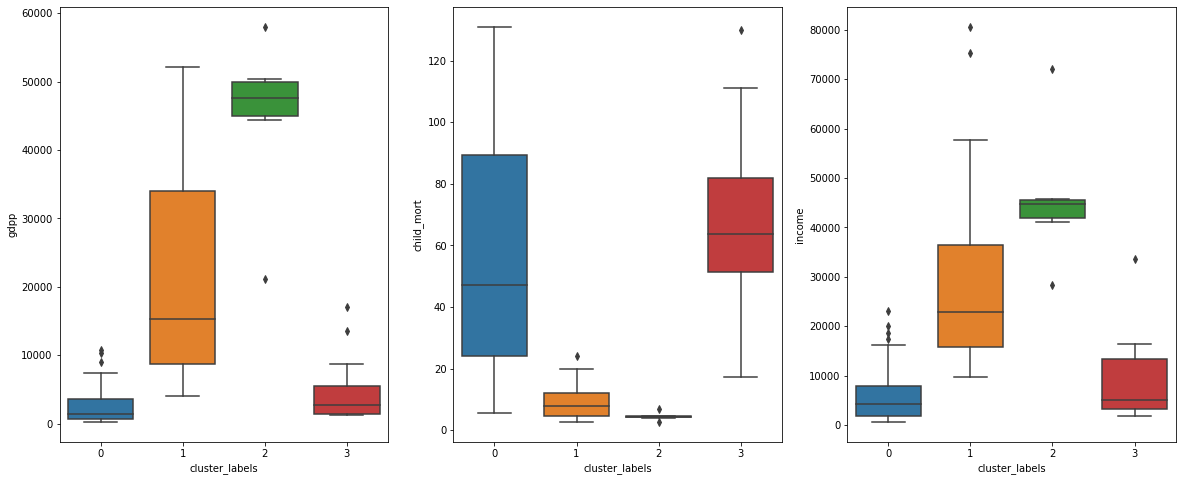

In [88]:
# plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_labels', y='gdpp', data=fourClusterData)

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_labels', y='child_mort', data=fourClusterData)

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_labels', y='income', data=fourClusterData)

### Observation
The cluster 0 , 3 exhibit similar traits. So breaking down into 4 migh not be very useful. 

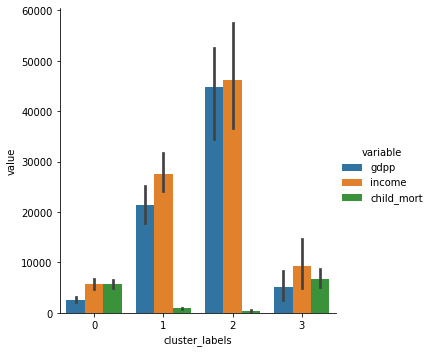

In [89]:
pltData = pd.melt(fourClusterData, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='bar')

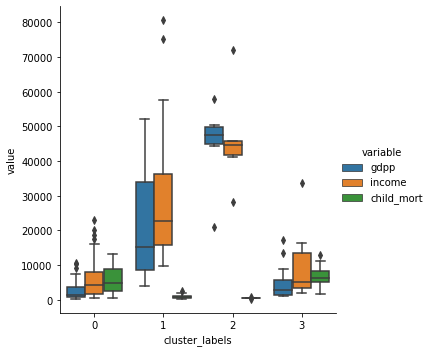

In [90]:
pltData = pd.melt(fourClusterData, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_labels'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_labels', y='value', hue='variable', data=pltData, kind='box')

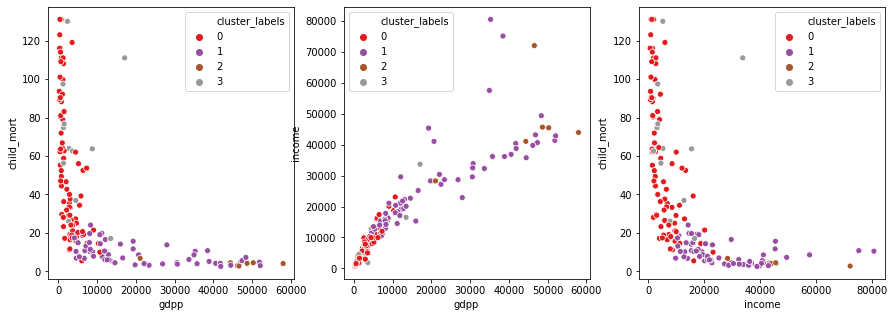

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_labels', legend='full', data = fourClusterData, palette='Set1')

plt.subplot(1, 3, 2)
sns.scatterplot(x='gdpp', y='income', hue='cluster_labels', legend='full', data = fourClusterData, palette='Set1')

plt.subplot(1, 3, 3)
sns.scatterplot(x='income', y='child_mort', hue='cluster_labels', legend='full', data = fourClusterData, palette='Set1')


### Observation 

We can confirm that cluster 0 , 3 are overlapping very significantly esp in child moratlity rate and income. 

In [92]:
fourClusterData.loc[(fourClusterData.cluster_labels==0)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2060.52,26.7960,9055.2,0
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,6245.70,38.5860,30280.2,0
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,13727.40,26.4194,16566.4,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,7725.60,17.9568,17086.8,0
132,Sierra Leone,131.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,6703.20,52.2690,13765.5,0
93,Madagascar,62.2,25.00,3.77,43.0,1390,8.79,60.8,4.60,413,10325.00,15.5701,17759.0,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,13198.50,21.8299,19357.8,0
31,Central African Republic,131.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,5262.80,17.7508,11819.0,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,10465.20,30.2481,16019.1,0
50,Eritrea,55.2,4.79,2.66,23.3,1420,11.60,61.7,4.61,482,2308.78,12.8212,11230.6,0


In [93]:
fourClusterData.loc[(fourClusterData.cluster_labels==3)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_labels
99,Mauritania,97.4,50.7,4.41,61.2,3320,18.9,68.2,4.98,1200,60840.0,52.920,73440.0,3
59,Ghana,74.7,29.5,5.22,45.9,3060,16.6,62.2,4.27,1310,38645.0,68.382,60129.0,3
165,Yemen,56.3,30.0,5.18,34.4,4480,23.6,67.5,4.67,1310,39300.0,67.858,45064.0,3
142,Sudan,76.7,19.7,6.32,17.2,3370,19.6,66.3,4.88,1480,29156.0,93.536,25456.0,3
113,Nigeria,130.0,25.3,5.07,17.4,5150,46.0,60.5,5.84,2330,58949.0,118.131,40542.0,3
103,Mongolia,26.1,46.7,5.44,56.7,7710,46.0,66.2,2.64,2650,123755.0,144.160,150255.0,3
38,"Congo, Rep.",63.9,85.1,2.46,54.7,5190,20.7,60.4,4.95,2740,233174.0,67.404,149878.0,3
149,Timor-Leste,62.6,2.2,9.12,27.8,1850,26.5,71.1,6.23,3600,7920.0,328.320,100080.0,3
72,Iraq,36.9,39.4,8.41,34.1,12700,16.6,67.2,4.56,4500,177300.0,378.450,153450.0,3
55,Gabon,63.7,57.7,3.50,18.9,15400,16.6,62.9,4.08,8750,504875.0,306.250,165375.0,3


### Observation 
Since we have seen that child mortality and income have overlaps. the groups are split into some with higher end of GDP

# K - Means Clustering

Text(0.5, 1.0, 'Elbow curve')

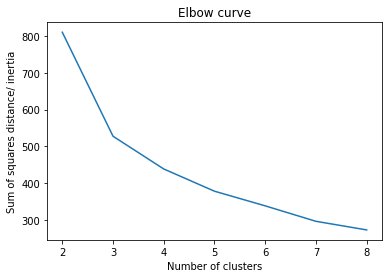

In [94]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(countries_info_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares distance/ inertia')
plt.title('Elbow curve')

### Observation
- the curve smoothens at k=3. Therfore it can be a good starting choice. 

For n_clusters=2, the silhouette score is 0.47126151872237554
For n_clusters=3, the silhouette score is 0.4058532781782057
For n_clusters=4, the silhouette score is 0.39605850512321567
For n_clusters=5, the silhouette score is 0.36541917393545253
For n_clusters=6, the silhouette score is 0.30592045889649044
For n_clusters=7, the silhouette score is 0.3036833526299667
For n_clusters=8, the silhouette score is 0.3005866689632928


Text(0.5, 1.0, 'Shilhoutte score vs cluster count')

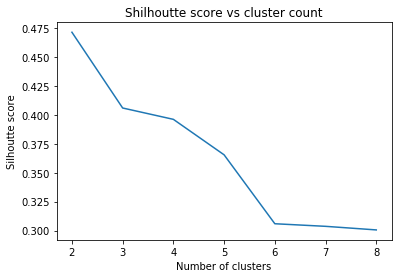

In [95]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
ss = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(countries_info_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(countries_info_scaled, cluster_labels)
    ss.append([num_clusters, silhouette_avg])
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('Shilhoutte score vs cluster count')

### Observation
- there is steep decrease in silhoutte score from 2 to 3 but curve soomethens after that. 
- we also observe a steep fall after 5 clusters. But that is a high number of clusters considering the features under observation. 


### Based on above 2 metrics we decide to go with 3 clusters to start with. We will also explore the higher number of clusters

In [96]:
# model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(countries_info_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [97]:
newData['cluster_id'] = kmeans.labels_
kmeans3Data = newData.copy(deep=True)
newData.drop('cluster_id', axis=1, inplace=True)

In [98]:
kmeans3Data.groupby('cluster_id')['gdpp'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,82.0,6287.463415,4444.091131,592.0,2970.0,4670.0,9017.5,19300.0
1,48.0,1909.208333,2925.911009,231.0,551.5,932.0,1465.0,17100.0
2,33.0,36972.727273,11268.908352,16600.0,28000.0,38500.0,46600.0,58000.0


In [99]:
kmeans3Data.groupby('cluster_id')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,82.0,12304.756098,8112.480588,1990.0,6702.5,10180.0,16450.0,45400.0
1,48.0,3897.354167,5590.168621,609.0,1390.0,1860.0,3522.5,33700.0
2,33.0,40381.818182,13725.738927,22900.0,30400.0,38800.0,43200.0,80600.0


In [100]:
kmeans3Data.groupby('cluster_id')['child_mort'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,82.0,21.951220,13.880471,4.5,11.550,18.35,28.65,64.4
1,48.0,88.506250,27.547811,28.1,63.675,89.75,111.00,131.0
2,33.0,5.281818,2.611208,2.6,3.800,4.20,6.20,13.8


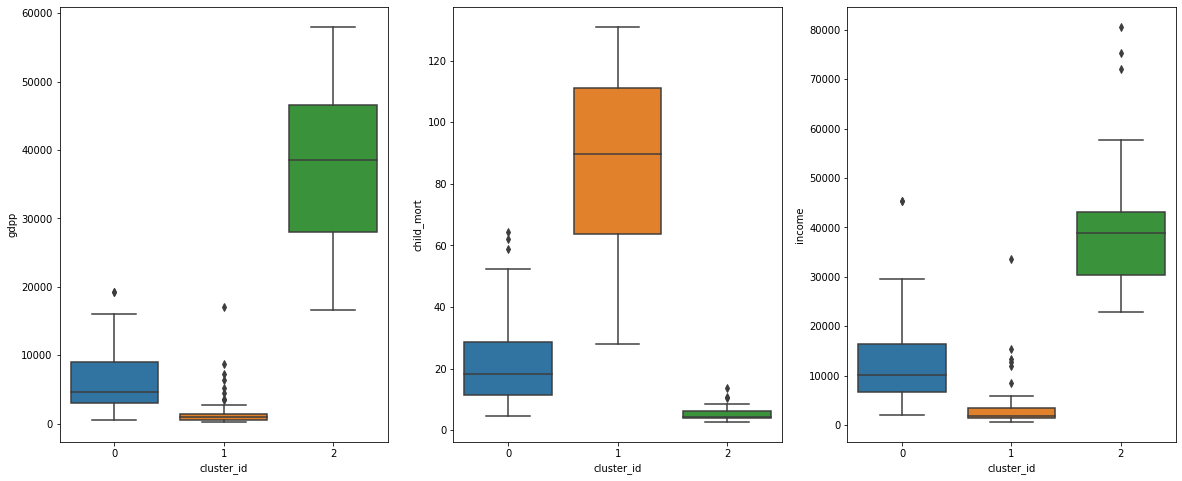

In [101]:
# plots
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id', y='gdpp', data=kmeans3Data)

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id', y='child_mort', data=kmeans3Data)

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id', y='income', data=kmeans3Data)

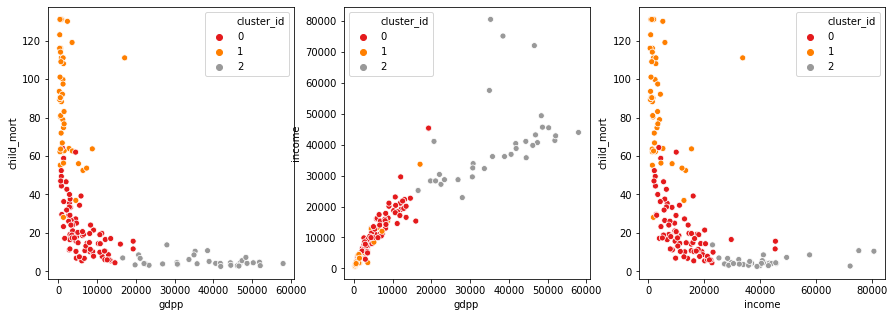

In [102]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id', legend='full', data = kmeans3Data, palette='Set1')

plt.subplot(1, 3, 2)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id', legend='full', data = kmeans3Data, palette='Set1')

plt.subplot(1, 3, 3)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id', legend='full', data = kmeans3Data, palette='Set1')

<Figure size 576x720 with 0 Axes>

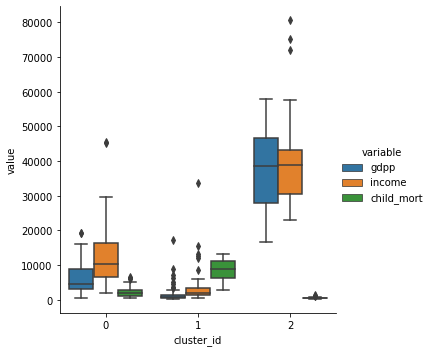

In [103]:
plt.figure(figsize=(8, 10))
pltData = pd.melt(kmeans3Data, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_id'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_id', y='value', hue='variable', data=pltData, kind='box')

### Observation
- The three clusters clearly have different characterstics as depicted by the graphs above. 
- These are divided into low gdp, high gdp and the middle range. 
- Child moratlity rate and incomes are also distinctly different. 
- Relationships identified during EDA hold. 

In [117]:
kmeans3Data.loc[(kmeans3Data.cluster_id==1)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_id
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2060.52,26.7960,9055.2,1
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,6245.70,38.5860,30280.2,1
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,13727.40,26.4194,16566.4,1
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,7725.60,17.9568,17086.8,1
132,Sierra Leone,131.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,6703.20,52.2690,13765.5,1
93,Madagascar,62.2,25.00,3.77,43.0,1390,8.79,60.8,4.60,413,10325.00,15.5701,17759.0,1
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,13198.50,21.8299,19357.8,1
31,Central African Republic,131.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,5262.80,17.7508,11819.0,1
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,10465.20,30.2481,16019.1,1
50,Eritrea,55.2,4.79,2.66,23.3,1420,11.60,61.7,4.61,482,2308.78,12.8212,11230.6,1


In [118]:
kmeans3Data.loc[(kmeans3Data.cluster_id==1)].sort_values(by=['child_mort', 'income', 'gdpp' ], ascending = [False, True, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster_id
31,Central African Republic,131.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,5262.8,17.7508,11819.0,1
132,Sierra Leone,131.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,6703.2,52.2690,13765.5,1
66,Haiti,131.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,10128.6,45.7442,42831.4,1
97,Mali,131.0,22.8,4.98,35.1,1870,4.37,59.5,6.55,708,16142.4,35.2584,24850.8,1
32,Chad,131.0,36.8,4.53,43.5,1930,6.39,56.5,6.59,897,33009.6,40.6341,39019.5,1
113,Nigeria,130.0,25.3,5.07,17.4,5150,46.00,60.5,5.84,2330,58949.0,118.1310,40542.0,1
112,Niger,123.0,22.2,5.16,49.1,814,2.55,58.8,7.49,348,7725.6,17.9568,17086.8,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,219919.0,100.6050,151437.0,1
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334,13727.4,26.4194,16566.4,1
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,11040.0,38.7550,17020.0,1


### model with k=4

In [106]:
# model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(countries_info_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [107]:
newData['cluster_id'] = kmeans.labels_
kmeans4Data = newData.copy(deep=True)
newData.drop('cluster_id', axis=1, inplace=True)

In [108]:
kmeans4Data.groupby('cluster_id')['gdpp'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,48.0,1909.208333,2925.911009,231.0,551.5,932.0,1465.0,17100.0
1,8.0,46012.500000,10893.830167,21100.0,46050.0,47800.0,50750.0,58000.0
2,27.0,32985.185185,10330.116676,16600.0,22950.0,33700.0,41200.0,51900.0
3,80.0,5962.150000,3981.964247,592.0,2967.5,4635.0,8440.0,16000.0


In [109]:
kmeans4Data.groupby('cluster_id')['child_mort'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,48.0,88.506250,27.547811,28.1,63.675,89.75,111.000,131.0
1,8.0,4.275000,1.213908,2.8,3.825,4.25,4.500,6.8
2,27.0,6.203704,3.543953,2.6,3.850,4.60,7.950,15.7
3,80.0,22.157500,13.988465,4.5,11.425,18.70,29.125,64.4


In [110]:
kmeans4Data.groupby('cluster_id')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,48.0,3897.354167,5590.168621,609.0,1390.0,1860.0,3522.5,33700.0
1,8.0,45350.000000,12170.925543,28300.0,42450.0,43600.0,45550.0,72100.0
2,27.0,39277.777778,13602.526161,22900.0,30000.0,36200.0,41250.0,80600.0
3,80.0,11478.625000,6256.357727,1990.0,6635.0,9950.0,16225.0,29600.0


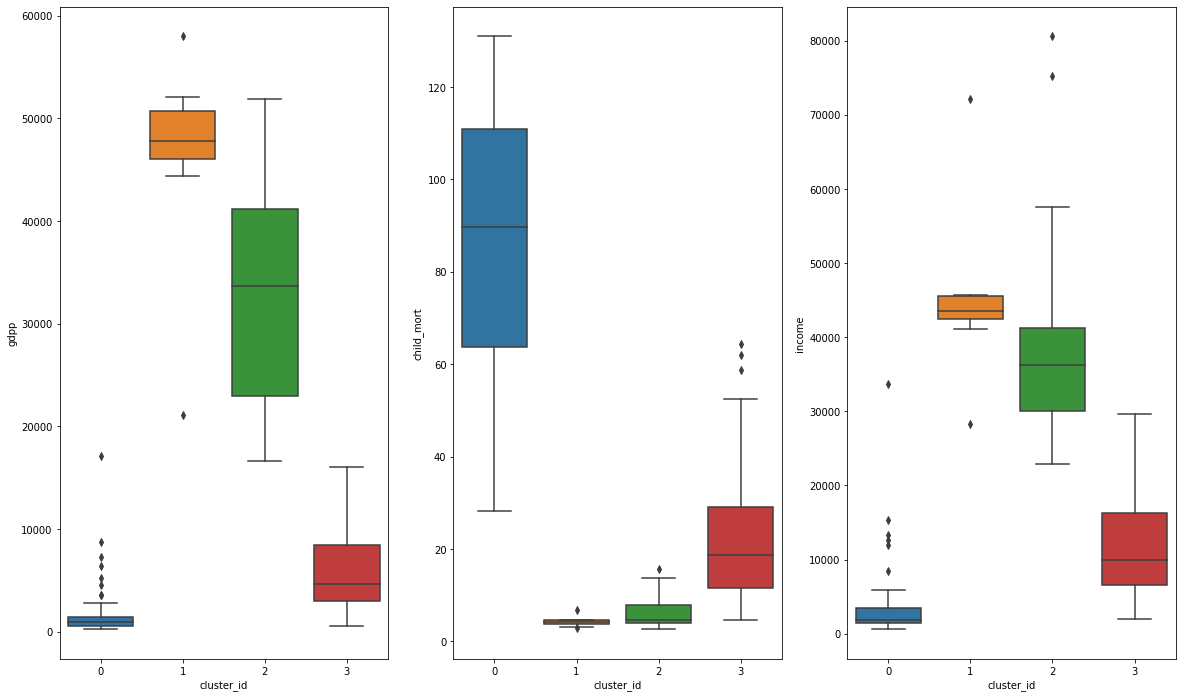

In [111]:
# plots
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id', y='gdpp', data=kmeans4Data)

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id', y='child_mort', data=kmeans4Data)

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id', y='income', data=kmeans4Data)

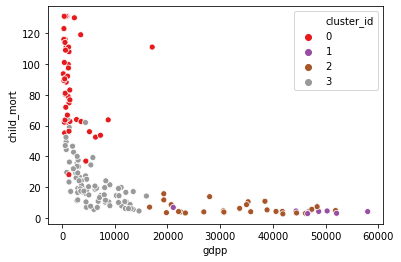

In [112]:
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id', legend='full', data = kmeans4Data, palette='Set1')


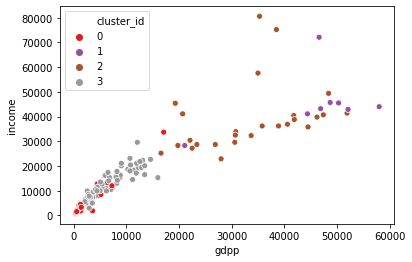

In [113]:
sns.scatterplot(x='gdpp', y='income', hue='cluster_id', legend='full', data = kmeans4Data, palette='Set1')


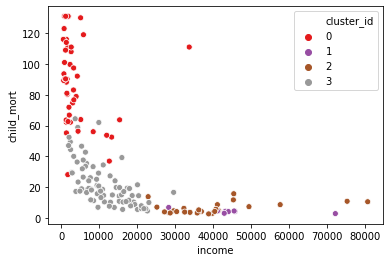

In [114]:
sns.scatterplot(x='income', y='child_mort', hue='cluster_id', legend='full', data = kmeans4Data, palette='Set1')

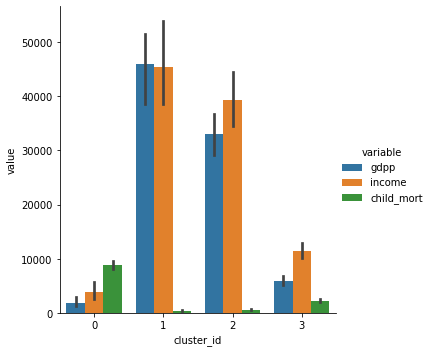

In [115]:
pltData = pd.melt(kmeans4Data, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_id'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_id', y='value', hue='variable', data=pltData, kind='bar')

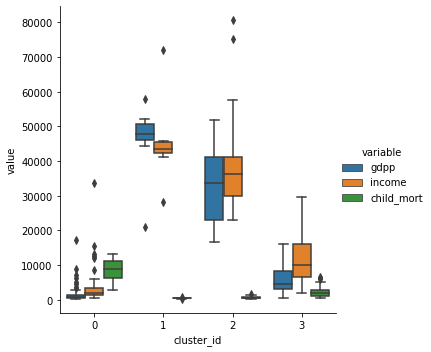

In [116]:

pltData = pd.melt(kmeans4Data, value_vars=['gdpp', 'income', 'child_mort'] , id_vars=['cluster_id'])
pltData.loc[pltData.variable=='child_mort' , 'value'] = pltData['value']*100
sns.catplot(x='cluster_id', y='value', hue='variable', data=pltData, kind='box')

### Observation
We see the higher GDP group has split up. However, the 2 clusters have similar traits. this does not help in improving the decision making. Therefore we go with the results obtained with 3 clusters. 